In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
NOTEBOOK_NAME = 'decoding_preVSpost'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'f', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


Exception KeyError: KeyError(0,) in 'h5py._objects.ObjectID.__dealloc__' ignored


In [6]:
vars_pre = {}
folder = '../pre/notebooks/autorestore/preprocessing'
for var in ('time_ax', 'events', 'cycles', 'is_CSmt', 'is_rewardt',
            'CYCLE_START', 'CS_DURATION', 'DELAY'):
    vars_pre.update({var:ut.load_variable(var, folder=folder)})
    
vars_post = {}
folder = '../post/notebooks/autorestore/preprocessing'
for var in ('time_ax', 'events', 'cycles', 'is_CSmt', 'is_rewardt',
            'CYCLE_START', 'CS_DURATION', 'DELAY'):
    vars_post.update({var:ut.load_variable(var, folder=folder)})

In [7]:
import h5py
filepath = '../data/cellreg_preVSpost.mat'
arrays = {}
f = h5py.File(filepath)
cellreg_map = np.array(f['cell_registered_struct']['cell_to_index_map'])-1
keep = np.prod(cellreg_map, 0)>0
cellregs = dict(zip(['pre', 'post'], cellreg_map.T[keep].T.astype(int)))

In [8]:
patterns_evs_pre = ut.extract_patterns(vars_pre['time_ax'], vars_pre['events'], vars_pre['cycles'],
                                       vars_pre['CYCLE_START'], vars_pre['CS_DURATION'], vars_pre['CS_DURATION'] + vars_pre['DELAY'])

patterns_evs_post = ut.extract_patterns(vars_post['time_ax'], vars_post['events'], vars_post['cycles'],
                                       vars_post['CYCLE_START'], vars_post['CS_DURATION'], vars_post['CS_DURATION'] + vars_post['DELAY'])

patterns_CS_evs_pre = ut.extract_patterns(vars_pre['time_ax'], vars_pre['events'], vars_pre['cycles'],
                                       vars_pre['CYCLE_START'], 0, vars_pre['CS_DURATION'])

patterns_CS_evs_post = ut.extract_patterns(vars_post['time_ax'], vars_post['events'], vars_post['cycles'],
                                       vars_post['CYCLE_START'], 0, vars_post['CS_DURATION'])

labels_pre = (np.r_[vars_pre['is_rewardt']] * 1)
labels_post = (np.r_[vars_post['is_rewardt']] * 1)

In [9]:
patterns_evs_pre = patterns_evs_pre[:, cellregs['pre']]
patterns_evs_post = patterns_evs_post[:, cellregs['post']]
patterns_CS_evs_pre = patterns_CS_evs_pre[:, cellregs['pre']]
patterns_CS_evs_post = patterns_CS_evs_post[:, cellregs['post']]

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut

# Decoding odor

  ## Train/test on same day

In [11]:
decoder = LinearSVC()
# decoder = MultinomialNB()
cv = LeaveOneOut() #StratifiedKFold(n_splits=30)
perf_pre = cross_val_score(decoder, patterns_evs_pre, labels_pre, cv=cv)
perf_post = cross_val_score(decoder, patterns_evs_post, labels_post, cv=cv)

## Train on pre test on post and vv.

In [12]:
perf_prepost = []

decoder.fit(patterns_evs_pre, labels_pre)
perf_prepost.append(decoder.score(patterns_evs_post, labels_post))

decoder.fit(patterns_evs_post, labels_post)
perf_prepost.append(decoder.score(patterns_evs_pre, labels_pre))

In [13]:
from matplotlib.lines import Line2D

(0, 100)

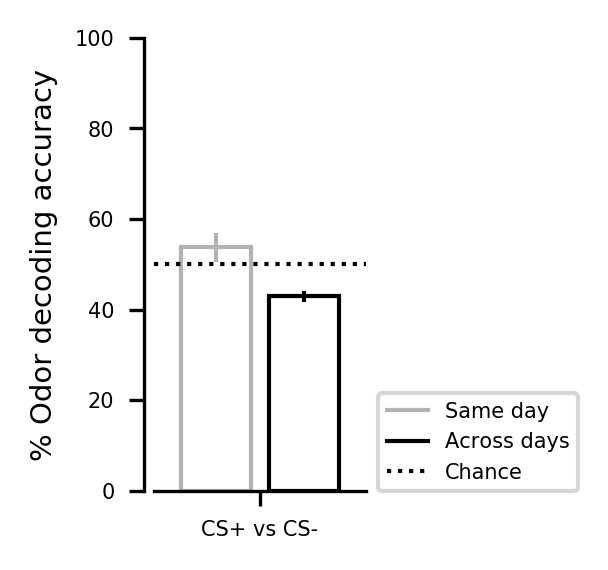

In [14]:
fig, ax = pl.subplots(1, 1, figsize=(1, 2))

values = [np.concatenate([perf_pre, perf_post]),  # 3 odors, same day
         ]

pt.plot_bars(np.r_[values]*100, xpos=np.arange(len(values))*3-0.5, colors='0.7', ax=ax, stderr=True)

values = [perf_prepost,  # 3 odors, cross day
         ]

pt.plot_bars(np.r_[values]*100, xpos=np.arange(len(values))*3+0.5, colors='k', ax=ax, stderr=True)
ax.set_xticks(np.arange(1))

pt.nicer_plot(ax)
ax.spines['bottom'].set_bounds(-1.2, 1.2)

ax.set_xticklabels(['CS+ vs CS-',])

ax.hlines(50, -1.2, 1.2, linestyles='dotted', lw=1)

ax.legend((Line2D('', '', color='0.7', lw=1),
           Line2D('', '', color='k', lw=1),
           Line2D('', '', color='k', linestyle='dotted', lw=1)),
          ['Same day', 'Across days', 'Chance'],
          fontsize=5, loc=(1.01, 0))

ax.set_ylabel('% Odor decoding accuracy')

ax.set_ylim(0, 100)

# pl.savefig('decoding_prepost_all_odors', format="pdf", bbox_inches="tight")

In [15]:
save_workspace(db);

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
